# Summarial Data Analysis

In [52]:
import pandas as pd
import numpy as np
import os
import sys

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

#plt.rcParams['text.usetex'] = True


To download the dataset, use or adapt the following:

In [ ]:
import subprocess

current_directory = os.getcwd()

# Define the scp command
scp_command = f"scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-fulldat-first100.csv {current_directory}/data_utils/."
subprocess.run(scp_command, shell=True)

scp_command = f"scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-full-dataset.csv {current_directory}/data_utils/."
subprocess.run(scp_command, shell=True)

Note that the full dataset is around 6.5 GB.

TODO: Host dataset somewhere accessible publicly.

## Reading the full RaCA dataset into memory

You can use the first 100 entries if you prefer to keep your workflow memory-light for test purposes:

In [133]:
current_directory = os.getcwd()
joined = pd.read_csv(f"{current_directory}/data_utils/RaCA-fulldat-first100.csv")

Otherwise, import the full dataset as follows:

In [134]:
current_directory = os.getcwd()
joined = pd.read_csv(f"{current_directory}/data_utils/RaCA-full-dataset.csv")

## Understanding SOC estimates

First, before implementing selection cuts, let's understand how many datapoints we have and what they signify.

In [207]:
print("Total nonzero TC entries:",((full['c_tot_ncs'] != 0).astype(int)).sum())
print("Total nonnegative TC entries:",((full['c_tot_ncs'] >= 0).astype(int)).sum())
print("Total negative TC entries:",((full['c_tot_ncs'] <= 0).astype(int)).sum())
print()
print("Total nonzero SOC entries:",((full['soc'] != 0).astype(int)).sum())
print("Total nonnegative SOC entries:",((full['soc'] >= 0).astype(int)).sum())
print("Total negative SOC entries:",((full['soc'] < 0).astype(int)).sum())
print()
print("TODO: 'caco3' entry should really just be CO3 content, not strictly calcite. Confirm with soilDB admins.")
print("Total nonzero carbonate entries:",((full['caco3'] != 0).astype(int)).sum())
print("Total nonnegative carbonate entries:",((full['caco3'] >= 0).astype(int)).sum())
print("Total negative carbonate entries:",((full['caco3'] < 0).astype(int)).sum())
print()
print("Total nonzero 351nm reflectance entries:",((full['351'] != 0).astype(int)).sum())
print("Total nonnegative 351nm reflectance entries:",((full['351'] >= 0).astype(int)).sum())
print("Total negative 351nm reflectance entries:",((full['351'] < 0).astype(int)).sum())

Total nonzero TC entries: 352850
Total nonnegative TC entries: 80878
Total negative TC entries: 0

Total nonzero SOC entries: 351930
Total nonnegative SOC entries: 352850
Total negative SOC entries: 0

TODO: 'caco3' entry should really just be CO3 content, not strictly calcite. Confirm with soilDB admins.
Total nonzero carbonate entries: 352850
Total nonnegative carbonate entries: 42406
Total negative carbonate entries: 1458

Total nonzero 351nm reflectance entries: 352850
Total nonnegative 351nm reflectance entries: 352374
Total negative 351nm reflectance entries: 476


The takeaway from the above is that:
- We have 80,878 analyses of total carbon
- We have only 43,406 analyses of calcite content
- Thus, the maximum number of direct SOC estimates we can make from TC - CO3 is 43,406
- We have more analyses of SOC than total carbon
- Thus, SOC estimates are not coming from laboratory estimates
- SoilDB documentation indicates these SOC values are modeled from the spectral data

The immediate next questions are:
- How many of the SOC values are not modeled?
- When a direct SOC estimate is available, is that reflected as TC - CO3 in some way?

Here are the fields scraped from soilDB in the Pandas dataframe:

- rcapid: RaCA pedon ID
- sample_top: Depth of top of sample (cm)
- sample_bottom: Depth of bottom of sample (cm)
- hzname_x: Horizon classification (x vs y?)
- texture_x: USDA texture classification
- frag_vol: % by volume of the sample that is >2mm in size (and does not enter scan) (?)
- bd: Bulk density (units?)
- bd_sd: Standard deviation of bulk density (units?)
- bd_source: Either "modeled" or "measured"
- bd_method: How bulk density was determined
- soc: Soil organic carbon mass fraction
- soc_sd: Standard deviation of SOC content (absolute/relative?)
- soc_measured: Either "modeled" or "measured"
- soc_scan: Always NaN
- soc_lab: SOC content determined in the lab (?)
- x: Approximate longitude of sample
- y: Approximate latitude of sample
- pedon_id: (rcapid) + "-" + (sample number within pedon)
- samp: (rcapid) - (last digit of rcapid) + "-" + (sample number within pedon)
- sample.id: (?)
- TOP: Depth of top of pedon (cm) (?)
- BOT: Depth of bottom of pedon (cm) (?)
- hzn_desgn: Horizon designation (similar to classification?)
- rcasiteid: (rcapid) - (last digit of rcapid) (?)
- pedon_no: Pedon number within sample campaign
- MO: (?)
- MOGr: (?) something related to land use?
- hor_top: Depth of top of horizon
- hor_bot: Depth of bottom of horizon
- fragvolc: % by volume of the sample that is >2mm in size (and does not enter scan) (?)
- Bulkdensity: Same as bd?
- SOC_pred1: SOC mass abundance prediction
- BD1: Something related to bulk density?
- upedonid: Roughly the same as pedon_id?
- upedon: Roughly the same as rcapid?
- LU: Land use classification
- MOGrLU: Something related to land use (?)
- hzname_y: Horizon classification (x vs y?)
- model_desg1: (?)
- texture_y: USDA texture classification (x vs y?)
- BDmeasured: Either "modeled" or "measured"
- BDmethod: How bulk density was determined
- Lab.Sample.No: ID for laboratory purposes (?)
- lab_proj_name: Separate ID for laboratory purposes (?)
- submit_proj_name: Always "RaCA MO(N1) Analysis/Archived Part N2"
- user_site_id: Possible same as rcapid (?)
- smp_id: (?)
- lay_field_label1: (?) str
- lay_field_label2: (?) str
- lay_field_label3: (?) str
- lay_depth_to_top: (?) (cm?)
- lay_depth_to_bottom: (?) (cm?)
- horizon_designation: Horizon classification (x vs y vs this? all different)
- natural_key: (?)
- lay_id: (?)
- adod: Ratio of (Air dried sample mass)/(Oven dried sample mass)
- c_tot_ncs: Total carbon content
- n_tot_ncs: Total nitrogen content
- s_tot_ncs: Total sulfur content
- caco3: Total carbonate content
- efferv_1nhcl: Results of an effervescence test
- M: (?)
- Model_desg: (?) same as model_desg1?
- Texture: USDA texture classification
- Measure_BD: Measured bulk density (units?)
- Model_BD: Modeled bulk density (units?)

## Implementing selection cuts

If ADOD is the ratio of air-dried mass to oven-dried mass, then ADOD > 1 and the mass percentage of water in the air-dried sample is 1 - 1/ADOD.

If ADOD is too high, then there is a chance that the sample was not fully or properly air-dried before the VNIR scan data was collected. The possibility of this happening is reflected in the RaCA documentation: sample collection teams were originally permitted to collect both air-dried and field-moist samples. It is possible that this is noted somewhere in soilDB (TODO: check with admins), but it is not documented how to distinguish between spectra for identical samples where one is air-dried and one is field-moist. This means that spectral features associated to water in liquid phase could contaminate the data. As such, we should at minimum discard samples where ADOD is above some threshold. Here, we analyze this selection cut in detail. 

Total nonnegative SOC:  351930
Further require spectrum to exist: 351930
Further require ADOD to exist: 80570
Further require <20% water by mass: 80553


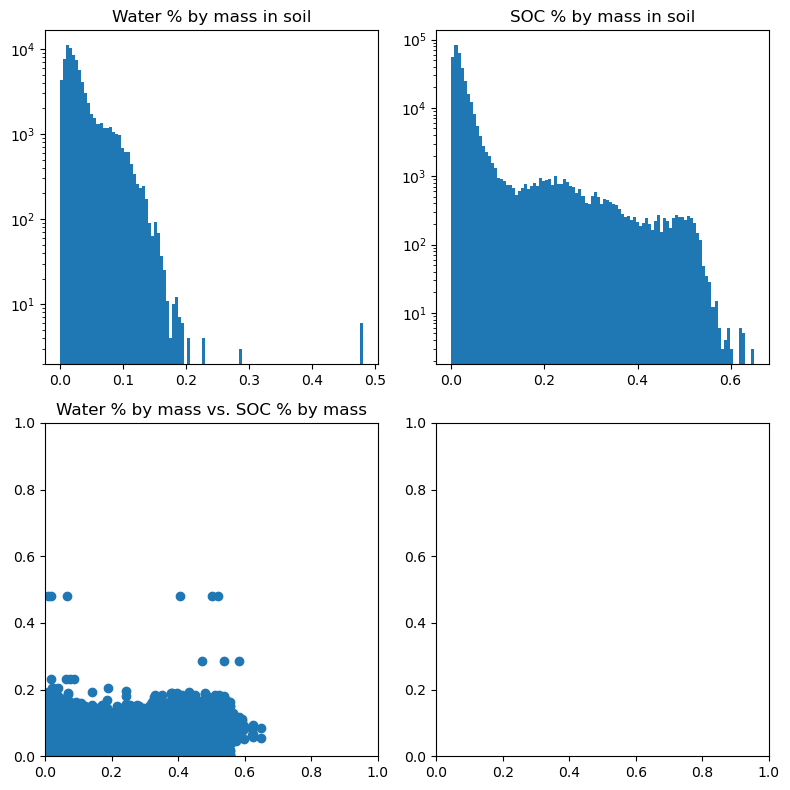

In [245]:
print("Total nonnegative SOC: ",((full['soc'] > 0).astype(int)).sum())
print("Further require spectrum to exist:",((full['soc'] > 0).astype(int) * (full['500'] > 0).astype(int)).sum())
print("Further require ADOD to exist:",((full['soc'] > 0).astype(int) * (full['500'] > 0).astype(int) * (full['adod'] > 0).astype(int)).sum())
print("Further require <20% water by mass:",((full['soc'] > 0).astype(int) * (full['500'] > 0).astype(int) * (full['adod'] > 0).astype(int) * ((1-1/full['adod']) < 0.2).astype(int)).sum())


fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot the first subplot
axs[0, 0].hist(1 - 1/full['adod'], bins=100)
axs[0, 0].set_title("Water % by mass in soil")
axs[0, 0].set_yscale('log')

# Plot the second subplot
axs[0, 1].hist(full['soc']/100, bins=100)
axs[0, 1].set_title("SOC % by mass in soil")
axs[0, 1].set_yscale('log')

# Plot the third subplot
axs[1, 0].scatter(full['soc']/100,(1-1/full['adod']))
axs[1, 0].set_title("Water % by mass vs. SOC % by mass")
axs[1, 0].set_xlim([0,1.])
axs[1, 0].set_ylim([0,1.])

# Plot the fourth subplot
# axs[1, 1].hist(1 - 1/full['adod'], bins=100)
# axs[1, 1].set_title("Water % by mass in soil")
# axs[1, 1].set_yscale('log')

# Adjust the spacing between subplots
plt.tight_layout()


## Splitting train/val by site 

## Plotting SOC spectral data $f_{SOC}(\lambda)$

Here is some sample code to generate nice plots of posterior distributions of $f_{SOC}(\lambda)$.

Immediately below are a list of wavelengths associated to spectral absorption by organic functional groups, as well as some helper variables.

In [57]:
organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]
MSpectra = 2151
NTest = 100
XF = np.array([x for x in range(350,2501)]);

Here we generate 100 fake seed spectra at random:

In [120]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

tFsoc = np.ones([NTest,MSpectra])*0.8
seedFsoc = tFsoc - 0.5*(np.random.randn(NTest,1)*0.6 + 0.3) *np.sum(fakeTrough((np.ones([1,MSpectra])*XF).T,np.array(organicTroughs),1000*gaus(1.0,0.35,len(organicTroughs))).T,axis=0)

Now we plot the reflectance quantiles:

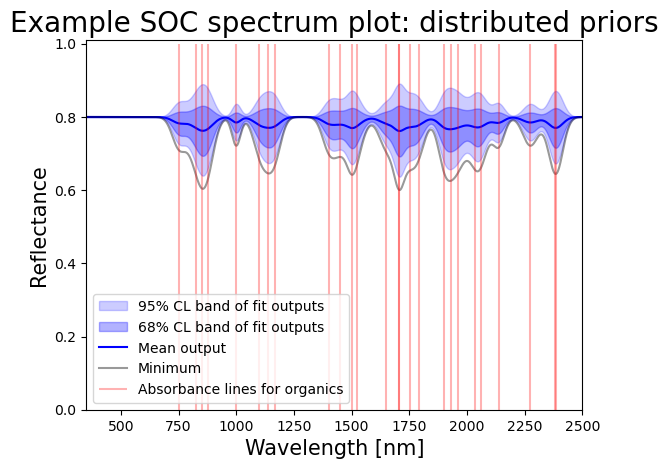

In [122]:
# Plot quantiles
#plt.fill_between(XF,np.quantile(socspecs,0.995,axis=0),np.quantile(socspecs,0.005,axis=0),color='blue',alpha=0.1,label=r'99\% CL band of fit outputs')
plt.fill_between(XF,np.quantile(seedFsoc,0.975,axis=0),np.quantile(seedFsoc,0.025,axis=0),color='blue',alpha=0.2,label=r'95% CL band of fit outputs')
plt.fill_between(XF,np.quantile(seedFsoc,0.84,axis=0),np.quantile(seedFsoc,0.16,axis=0),color='blue',alpha=0.3,label=r'68% CL band of fit outputs')

# Plot means and mins
plt.plot(XF,np.mean(seedFsoc,axis=0), color='blue', label=r'Mean output');
plt.plot(XF,np.min(seedFsoc,axis=0), color='black',alpha=0.4, label=r'Minimum');

# Style plot
plt.xlim([350.0,2500.0])
plt.ylim([0.0,1.01])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Example SOC spectrum plot: distributed priors',fontsize=20)

# Add absorbance lines for organics
plt.vlines(organicTroughs,ymin=0.0,ymax=1.0, color='red', alpha=0.3, label="Absorbance lines for organics")

# Add legend
plt.legend(loc='best');

## Plotting geographic data 

The pandas dataframe has a column called 'y' and 'x' which are latitudes and longitudes, respectively.

Here we make an example histogram plot of the density of the samples overlaid on a map of the United States.

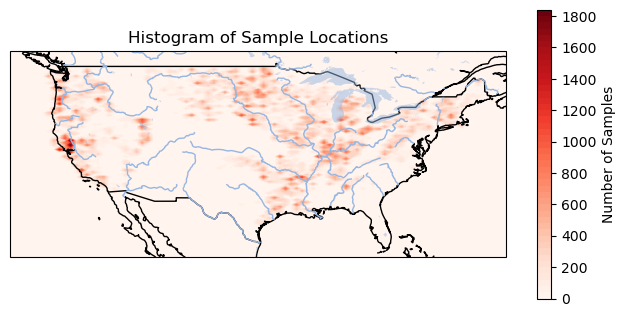

In [161]:
# Create a figure
fig = plt.figure(figsize=(8, 15))

# Create a GeoAxes in the figure
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
#ax.add_feature(cfeature.LAND, facecolor='0')
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add a latitude and longitude grid
#ax.gridlines(draw_labels=True)

# Overlay heatmap of number of samples for each 1x1 degree grid cell
# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(full['x'], full['y'], bins=90, range=[[-130, -65], [24, 51]])
# Plot the histogram2d
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Reds', vmin=1)
# Perform kerning on the heatmap
plt.gcf().gca().update_datalim(np.column_stack([full['x'], full['y']]))
# Make a contour plot of the heatmap
plt.contourf(xedges[:-1], yedges[:-1], hist.T, 50, cmap='Reds')

# Add a log colorbar
plt.colorbar(label='Number of Samples', shrink=0.25, pad=0.05, norm=LogNorm())

# Add a title
plt.title('Histogram of Sample Locations')

# Restrict to the continental United States
ax.set_extent([-130, -65, 24, 51])
plt.ylim(24,51)

# Show the plot
plt.show()
